# Utilizando deep-learning para solução de captcha

Importação das bibliotecas que serão utilizadas.

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import os
from imutils import paths
import imutils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

#Exibição na mesma tela do Jupyter
%matplotlib inline

plt.style.use('seaborn')
sns.set_style("whitegrid", {'axes.grid' : False})

from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

Using TensorFlow backend.
D:\ProgramData\Anaconda3\envs\visao-computacional\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\ProgramData\Anaconda3\envs\visao-computacional\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\ProgramData\Anaconda3\envs\visao-computacional\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Pr

Para criar um modelo de Deep Learning para reconhecimento de caracteres, vamos utilizar a base conhecida gerada de um sistema de captcha que foi utilizado nos sistemas do Tribunal Regional do Trabalho de São Paulo.

Neste exemplo, vamos utilizar somente os caracteres que aparecem na maior parte dos desafios de captcha, que na coleta foram de 33 letras e números.

A arquitetura e alguns componentes foram adaptados deste [artigo](https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d) de Orhan Gazi Yalçın.

## 1. Requerimentos

Utilize o comando ao lado para instalar pelo Anaconda terminal.

* OpenCV 3.4.3 (```conda install -c conda-forge opencv==3.4.3```)
* Keras 2.3.1 (```conda install keras==2.3.1```)
* Matplotlib 3.1.3 (```conda install matplotlib==3.1.3```)
* Seaborn 0.0.10 (```conda install -c conda-forge seaborn==0.10.0```)
* Imutils 0.5.3 (```conda install -c conda-forge imutils==0.5.3```)
* Scikit Learn 0.22.1 (```conda install scikit-learn==0.22.1```)

## 2. Pré-processamento

### 2.1 Identificando as classes

Como um gerador de captchas nem sempre explora todo o alfabeto, vamos identificar exatamente quais as letras são utilizadas para listar todas as possíveis classes deste problema.

In [4]:
pasta_imagens_treino = "captcha\\imagens\\"

lista_classes = []

for file in glob.glob(os.path.join("captcha\\imagens\\", "*")):
    lista_classes.append(file.split("\\")[-1])

lista_classes = list(set(lista_classes))
print(lista_classes)
print(len(lista_classes))

['c', 't', 'r', 'b', 'd', 'e', 'a', 'k', '9', '7', 'm', 'w', 'v', '8', '5', 'n', 'x', '6', 'i', 'z', 'f', 'y', 'u', 'g', '2', '3', 'o', 'p', '4', 'q', 's', 'h', 'j']
33


>Método alternativo: utilizando o método _paths_ do _imutils_ que lista todas a imagens, mesmo em subdiretórios.
Apenas testando o uso desta biblioteca.

In [5]:
# Obter somente 5 imagens
num_imagens = 5
conta = 0
for imagem_caminho in paths.list_images(pasta_imagens_treino):
    print(imagem_caminho)
    conta += 1
    if conta >= num_imagens:
        break

captcha\imagens\2\000001_2232r.png
captcha\imagens\2\000002_2232r.png
captcha\imagens\2\000003_2232r.png
captcha\imagens\2\000004_22ju4.png
captcha\imagens\2\000005_22ju4.png


### 2.2 Enquadramento de imagem

Vamos deixar uma borda de segurança entre as letras para evitar classificações indevidas.

In [6]:
def redimensionar_borda(imagem, comprimento, altura):

    # Obtendo as dimensões da imagem
    (h, w) = imagem.shape[:2]

    # Vamos deixar as imagens quadradas, logo se o comprimento for maior que a altura
    if w > h:
        imagem = imutils.resize(imagem, width=comprimento)
    else:
        imagem = imutils.resize(imagem, height=altura)

    # Ajustando a borda
    padW = int((comprimento - imagem.shape[1]) / 2)
    padH = int((altura - imagem.shape[0]) / 2)

    imagem = cv2.copyMakeBorder(imagem, padH, padH, padW, padW, cv2.BORDER_CONSTANT, value=[255,255,255])
    imagem = cv2.resize(imagem, (comprimento, altura), interpolation=cv2.INTER_LANCZOS4)

    return imagem

Exemplo de imagem com tamanho despadronizado.

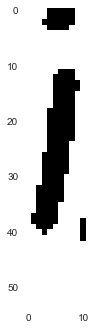

In [7]:
imagem = cv2.imread("captcha/imagens/i/000001_3ibaz.png")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.imshow(imagem)

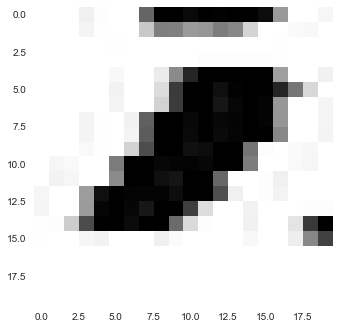

In [8]:
imagem_sem_borda = cv2.resize(imagem, (20, 20), interpolation=cv2.INTER_LANCZOS4)
plt.imshow(imagem_sem_borda)

Exemplo de imagem padronizada, com margem de segurança e tamanho único.

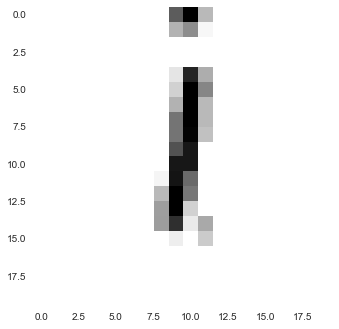

In [9]:
imagem_padronizada = redimensionar_borda(imagem, 20, 20)
plt.imshow(imagem_padronizada)

### 2.3 Treinamento

Colecionando imagens para treinamento e realizando pequenos ajustes para posterior uso na biblioteca de deep-learning do Keras.

In [10]:
classes = []
dados_imagem = []

for imagem_caminho in paths.list_images(pasta_imagens_treino):

    # Obtendo imagem e convertendo para escala de cinza
    imagem = cv2.imread(imagem_caminho)
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    imagem = redimensionar_borda(imagem, 20, 20)
        
    # Adicionando uma terceira dimensão (Canal Normalizado) conforme especificação do Keras
    imagem = np.expand_dims(imagem, axis=2)

    # Obtendo a caractere pelo nome do diretório
    classe = imagem_caminho.split(os.path.sep)[-2]
    
    dados_imagem.append(imagem)
    classes.append(classe)

Ao todo temos as seguintes quantidades de exemplos:

In [11]:
len(classes), len(dados_imagem)

(5053, 5053)

Vamos também simplificar a informação de escala de cinza. Utilizaremos a forma normalizada, dividindo todos os valores por 255. Desta forma um pixel 100% branco seria 1, e outro 100% preto seria 0.

In [12]:
dados_imagem = np.array(dados_imagem, dtype="float") / 255
classes = np.array(classes)

Realizando a divisão de treinamento e validação.

In [13]:
(x_train, x_test, y_train, y_test) = train_test_split(dados_imagem, classes, test_size=0.3, 
                                                      random_state=0)

len(x_train), len(x_test)

(3537, 1516)

O Keras trabalha com uma forma diferente dos dados. Ao invés de utilizar as 3 dimensões, precisaremos de mais uma dimensão para incluir as imagens que farão parte dos treinamentos e testes, obtendo **Número de Imagens, Comprimento, Largura, Canal Normalizado**.

In [14]:
print("Formato de dados da API Keras", x_train[0].shape)

Formato de dados da API Keras (20, 20, 1)


In [15]:
print('Imagens de treino (x) 20 x 20:', x_train.shape)
print('Quantidade de imagens de treino', x_train.shape[0])
print('Quantidade de imagens de treino', x_test.shape[0])

Imagens de treino (x) 20 x 20: (3537, 20, 20, 1)
Quantidade de imagens de treino 3537
Quantidade de imagens de treino 1516


Agora vamos definir a entrada dos dados, neste caso precisa ser exatamente da mesma forma que as imagens forem treinadas. Isso é portante pois a rede neural estará preparada para inferir somente imagens com este tamanho.

In [16]:
shape_entrada = (20, 20, 1)

Incluindo codificação _one-hot_, ou seja, um conjunto de dados que está associado as classes, logo um dos 33 caracteres será codificado com bit 1 de acordo com sua posição na lista.

In [17]:
lb = LabelBinarizer().fit(y_train)
y_train = lb.transform(y_train)
y_test = lb.transform(y_test)

Exemplo de uma amostra:

In [18]:
print(lista_classes)
print([lista_classes[7]])

['c', 't', 'r', 'b', 'd', 'e', 'a', 'k', '9', '7', 'm', 'w', 'v', '8', '5', 'n', 'x', '6', 'i', 'z', 'f', 'y', 'u', 'g', '2', '3', 'o', 'p', '4', 'q', 's', 'h', 'j']
['k']


In [19]:
y_train[1]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Abaixo vamos constuir um modelo simples, do zero. Como as imagens são bem simples, diversas arquiteturas funcionam.

Quando lidamos com objetos mais complexos, é bem comum optarmos por arquiteturas abertas como por exemplo:

*[VGG](http://www.robots.ox.ac.uk/~vgg/research/very_deep/) de Oxford
*[ResNet](https://arxiv.org/abs/1512.03385) da Microsoft
*[Inception](https://github.com/google/inception) do Google
*[Xception](https://arxiv.org/abs/1610.02357) do Google

Depois de avaliar estas arquiteturas, é possível adapta-las para classificar imagens específicas, isso se dá alterando as últimas camadas. É o que chamamos também de **Transfer Learning**.

Neste [link](https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5) você pode encontrar mais sobre outras arquiteturas.

In [20]:
numero_classes = len(lista_classes)
numero_classes

33

### 2.4 Arquitetura

Partimos de um modelo simples que na maioria das vezes resolve problemas de OCR como esse. Como foi citado, identificações mais complexas utilizamos outras aboragens ou evolução de uma arquitetura inicial como esta.

In [21]:
# Construindo um modelo sequencial
model = Sequential()

# Este componente, se trata de um filtro ou uma camada convulacional. Ela será responsável por 
# colocar uma janela de kernel (5x5), navegar pela imagem e extrair a soma dos pixels de cada janela
# o passo para mover a janela, chamado Stride, por padrão é de um pixel
model.add(Conv2D(20, kernel_size=(5,5), padding="same", input_shape=shape_entrada, activation="relu"))

# A camada de Pooling (ou MaxPooling2D) tem o papel de reduzir a dimensionalidade. Neste caso, a partir 
# da etapa anterior, será dividia em grupos de 2 x 2 pixels e será obtida o maior valor deles
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

# Esta etapa conhecida como "achatamento" é onde abrimos os dados organizados em tabelas (ou matrizes) 
# para uma única linha
model.add(Flatten())

# A camada densa (ou Dense) conectará cada elemento da camada anterior e passará para a próxima
# camada com as classes existentes
model.add(Dense(128, activation="relu"))

# O Dropout é um ruído gerado para evitar overfitting
model.add(Dropout(0.2))

# A camada final, determinará qual classe escolher. Por tal razão ela possui a ativação Softmax, que retorna 
# a probabilidade por classe
model.add(Dense(numero_classes, activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 20)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 20)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               256128    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 33)                4257      
Total params: 260,905
Trainable params: 260,905
Non-trainable params: 0
_________________________________________________________________


Para revisão de funções de ativação, em particular [Relu](https://matheusfacure.github.io/2017/07/12/activ-func/).

In [22]:
x_train[0].shape

(20, 20, 1)

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=10, batch_size=5)

Train on 3537 samples, validate on 1516 samples
Epoch 1/10
3537/3537 [==============================] - 17s 5ms/step - loss: 2.4830 - acc: 0.3277 - val_loss: 1.2715 - val_acc: 0.6913
Epoch 2/10
3537/3537 [==============================] - 16s 5ms/step - loss: 1.0573 - acc: 0.7105 - val_loss: 0.8127 - val_acc: 0.8113s: 1.1142  - ETA: 2 - ETA: 0s - loss: 1.0618 - 
Epoch 3/10
3537/3537 [==============================] - 16s 5ms/step - loss: 0.7224 - acc: 0.7976 - val_loss: 0.5647 - val_acc: 0.8753
Epoch 4/10
3537/3537 [==============================] - 16s 4ms/step - loss: 0.5489 - acc: 0.8623 - val_loss: 0.5032 - val_acc: 0.8766 0.5399 - acc:  - ETA: 8s - loss: 0.5487 - acc: 0.8 - ETA: 8s - ETA: 7s - loss: 0.5645 - - ETA: 6s - loss: 
Epoch 5/10
3537/3537 [==============================] - 16s 5ms/step - loss: 0.4634 - acc: 0.8824 - val_loss: 0.4615 - val_acc: 0.8984
Epoch 6/10
3537/3537 [==============================] - 18s 5ms/step - loss: 0.3727 - acc: 0.9084 - val_loss: 0.4176 - val_

Os gráficos a seguir mostram convergência de acurácia para os dados de treinamento e validação.
Note que o valor do erro, diferentemente da acurácia, não é expressada em porcentagem, portanto erro < 1 é um ótimo valor.

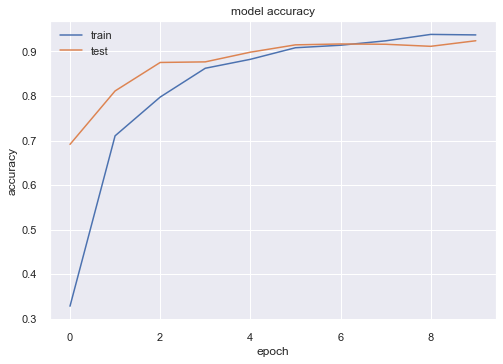

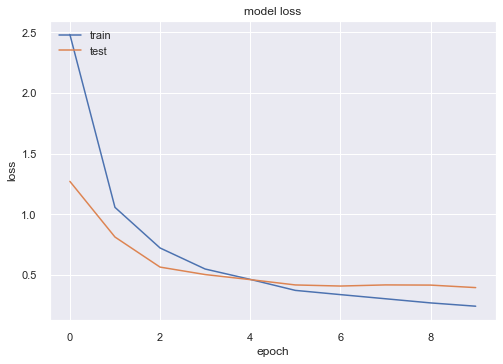

In [24]:
# Para deixar no formato do Seaborn os gráficos do Pyplot
sns.set()

# Exibindo dados de Acurácia/Precisão
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Exibindo dados de Perda
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Salvando o modelo para uso posterior. Mesmo imagens pequenas como essas levam vários minutos para treinar.

In [25]:
# Salvando o modelo no formato HDf5
model.save("modelos/model_captcha.h5")

# Arquitetura das camadas em JSSON e pesos treinados em HDF5
model.save_weights("pesos/weights_captcha.h5")

Uma vez salvo o modelo, nesta etapa é só carregar.

In [26]:
# carregando o modelo no formato HDf5
model = load_model("modelos/model_captcha.h5")  
model.load_weights("pesos/weights_captcha.h5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 20)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 20)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               256128    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 33)                4257      
Total params: 260,905
Trainable params: 260,905
Non-trainable params: 0
_________________________________________________________________


## 3. Validação

Vamos inferir algumas imagens para verificar visualmente como o classificador está se comportando.
Para isso definimos uma função para normalizar uma imagem do captcha, para extrair os ruídos e posteriomente cada uma das suas letras.

In [27]:
def imagem_normalizada(caminho_imagem):

    imagem = cv2.imread(caminho_imagem)
    imagem_gray = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    
    imagem_suavizada = cv2.GaussianBlur(imagem_gray, (5, 5), 0)
    _, imagem_limiarizada =  cv2.threshold(imagem_suavizada, 148, 255, cv2.THRESH_BINARY_INV)
    _, imagem_limiarizada =  cv2.threshold(imagem_limiarizada, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    kernel = np.ones((2, 2), np.uint8)
    imagem_erodida = cv2.erode(imagem_limiarizada, kernel, iterations = 2)

    return imagem_erodida

As etapas da função são as seguintes:

### 3.1 Conversão para escala de cinza

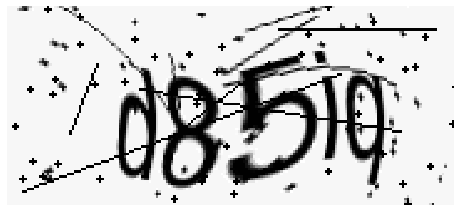

In [28]:
plt.axis('off')

imagem_caminho = "captcha/anotados/d85iq.png"

imagem_original = cv2.imread(imagem_caminho, cv2.IMREAD_GRAYSCALE)
plt.imshow(imagem_original, cmap='gray')

### 3.2 Suavização para preparação de limiarização

Esta operação visa remover os ruídos da imagem, como as linhas transversais e pequenos pontos.

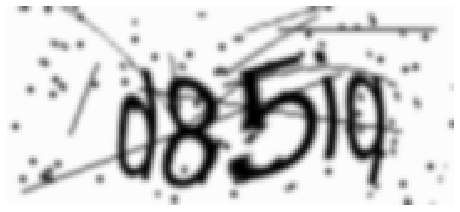

In [29]:
imagem = cv2.imread(imagem_caminho)
imagem_gray = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

imagem_suavizada = cv2.GaussianBlur(imagem_gray, (5, 5), 0)

plt.axis('off')
plt.imshow(imagem_suavizada, cmap='gray')

### 3.3 Limiarização

A limirização remove todos os ruídos baseado num valor de limiar.

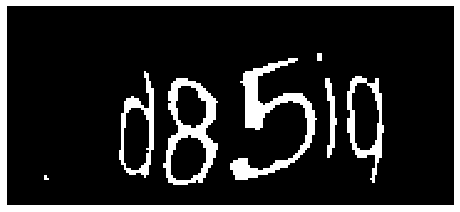

In [30]:
_, imagem_limiarizada =  cv2.threshold(imagem_suavizada, 148, 255, cv2.THRESH_BINARY_INV)

plt.axis('off')
plt.imshow(imagem_limiarizada, cmap='gray')

### 3.4 Inversão da imagem

Para se adequar as imagens de treinamento e para que fique mais nítido a visualização das letras.

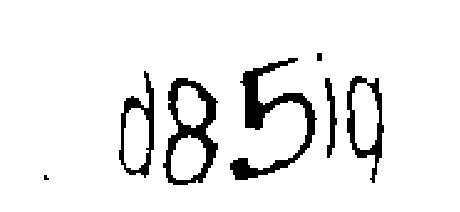

In [31]:
 _, imagem_limiarizada =  cv2.threshold(imagem_limiarizada, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

plt.axis('off')
plt.imshow(imagem_limiarizada, cmap='gray')

### 3.5 Erosão

Como a imagem está invertida, aplicamos uma erosão para intensificar as linhas e melhorar a nitidez.

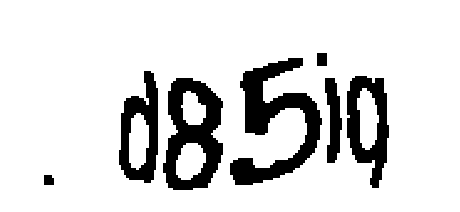

In [32]:
kernel = np.ones((2, 2), np.uint8)
imagem_erodida = cv2.erode(imagem_limiarizada, kernel, iterations = 2)

plt.axis('off')
plt.imshow(imagem_erodida, cmap='gray')

Execução da função. Neste caso não fizemos a inversão da imagem pois as letras foram treinadas com o fundo branco.

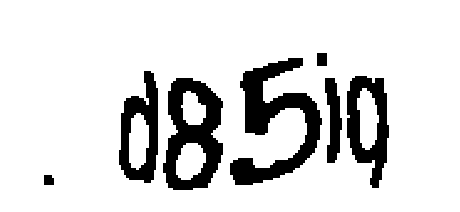

In [33]:
imagem_norm = imagem_normalizada(imagem_caminho)

plt.axis('off')
plt.imshow(imagem_norm, cmap='gray')

### 3.6 Identificação de contornos

Com a imagem com as letras bem definidas, iremos aplicar o método Canny para extrair os contornos.

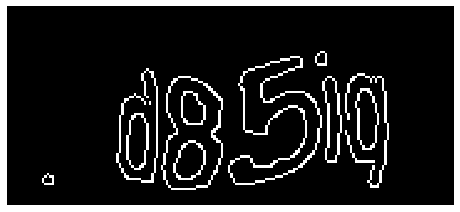

In [34]:
imagem_borda = cv2.Canny(imagem_norm, 30, 200)
_, contornos, _ = cv2.findContours(imagem_borda, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

plt.axis('off')
plt.imshow(imagem_borda, cmap="gray")

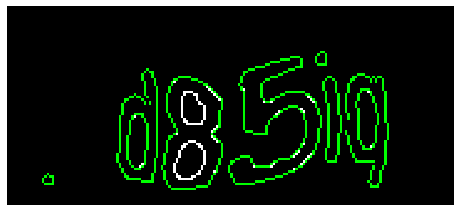

In [35]:
imagem_borda_contornos = imagem_borda.copy()
imagem_borda_contornos = cv2.cvtColor(imagem_borda_contornos, cv2.COLOR_GRAY2RGB)

cv2.drawContours(imagem_borda_contornos, contornos, -1, (0,255,0), 1)

plt.axis('off')
plt.imshow(imagem_borda_contornos)

In [36]:
len(contornos)

11

### 3.7 Extração das letras

A função a seguir, analisará os contornos identificados e fará um filtro baseado no tamanho do contorno. Em algumas ocasiões é possível ter contornos identificados em pequenos ruídos que ainda passam pelo processo, mas como eles são pequenos são facilmente identificados e removidos.

In [37]:
def obter_letras(imagem):
    
    contornos_letras = []
    
    imagem_borda = cv2.Canny(imagem, 30, 200)
    _, contornos, _ = cv2.findContours(imagem_borda, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contorno in contornos:
        (x, y, w, h) = cv2.boundingRect(contorno)

        area = int(w) * int(h)
        
        if area <250:
            continue
        
        contornos_letras.append((x, y, w, h))
    
    print("Identificado " + str(len(contornos_letras)) + " contornos válidos.")
    
    # Se detectar mais do que 5 letras, detecção inválida
    if len(contornos_letras) < 5 :
        return False
    
    contornos_letras = sorted(contornos_letras, key=lambda x: x[0])
    
    lista_imagem_letras = []
    
    for retangulo_letra in contornos_letras:
        x, y, w, h = retangulo_letra
        imagem_letra = imagem[y - 10:y + h + 30, x - 1:x + w + 1]
        lista_imagem_letras.append(imagem_letra)
        
    return lista_imagem_letras

O retorno da função é a lista de regiões de interesse das letras.

In [38]:
imagem_letras = obter_letras(imagem_norm)

Identificado 6 contornos válidos.


### 3.8 Validação com imagem completa

A função a seguir, dada uma imagem, vai padronizá-la e inferir letra a letra.

In [39]:
def obter_predicao(imagem):
    
    imagem_norm = redimensionar_borda(imagem, 20, 20)
    prediction = model.predict(imagem_norm.reshape(1, 20, 20, 1))
    label = lb.inverse_transform(prediction)[0]

    return label

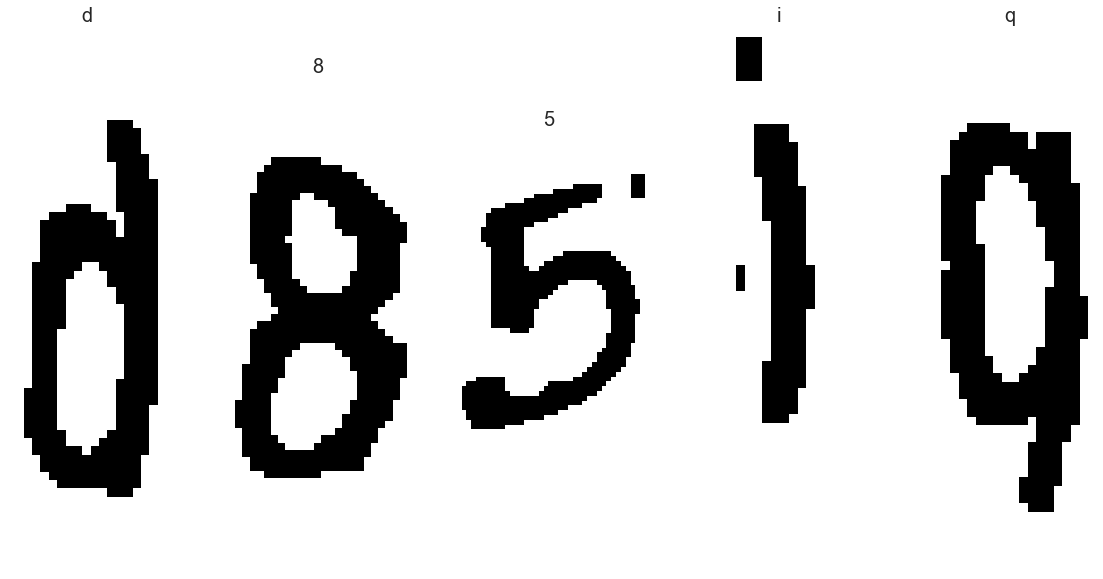

In [40]:
plt.figure(figsize=(20,10))
plt.subplot(151)
plt.title(obter_predicao(imagem_letras[0]), fontdict={'fontsize': 20})
plt.imshow(imagem_letras[0], cmap="gray")
plt.axis('off')

plt.subplot(152)
plt.title(obter_predicao(imagem_letras[1]), fontdict={'fontsize': 20})
plt.imshow(imagem_letras[1], cmap="gray")
plt.axis('off')

plt.subplot(153)
plt.title(obter_predicao(imagem_letras[2]), fontdict={'fontsize': 20})
plt.imshow(imagem_letras[2], cmap="gray")
plt.axis('off')

plt.subplot(154)
plt.title(obter_predicao(imagem_letras[3]), fontdict={'fontsize': 20})
plt.imshow(imagem_letras[3], cmap="gray")
plt.axis('off')

plt.subplot(155)
plt.title(obter_predicao(imagem_letras[4]), fontdict={'fontsize': 20})
plt.imshow(imagem_letras[4], cmap="gray")
plt.axis('off')
plt.show()